In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Goal: Real Disaster Tweet or Not
* Predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0

### Dataset
* kaggle competitions download -c nlp-getting-started

### Columns
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)



# Libraries

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud,STOPWORDS

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import spacy
from spacy import displacy

import string
import nltk
from nltk.corpus import stopwords, wordnet

from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB


# Read/Load Train Data

In [ ]:
root_path = "../input/nlp-getting-started"
train_path = os.path.join(root_path,"train.csv")
train = pd.read_csv(train_path)
train

# Read/Load Test Data

In [ ]:
test_path = os.path.join(root_path,"test.csv")
test = pd.read_csv(test_path)
test.shape

# Explore Train Data

### location feature

In [ ]:
train_location_uniques = [name for name in train.location.value_counts().index.sort_values()]
train_location_uniques[0:25] # location content first 25 rows

* location content is the mixture of country names & hash tags with some juck characters.

### Word Cloud on location content

In [ ]:
def draw_word_cloud(image_path, fig_title, words, fig_size, max_words):
    stop_words = set(STOPWORDS)
    mask_img = np.array(Image.open(image_path))
    wordcloud_masked = WordCloud(background_color='white', max_words=max_words, stopwords=stop_words,min_font_size=10,
                                 contour_width=5, contour_color='gray',mask=mask_img, width=mask_img.shape[1],
                                height=mask_img.shape[0]).generate(words)
    #Plotting the WordCloud
    plt.figure(figsize=fig_size)
    plt.imshow(wordcloud_masked)
    plt.title(fig_title, fontsize=30)
    plt.axis("off")
    plt.show() 
    return None

In [ ]:
location_path ='../input/locationpoint/location_pin.png'
draw_word_cloud(location_path, 'Location content', str(train_location_uniques), (35,12), 500)

### keyword feature

In [ ]:
def plot_donut(labels, values, fig_height, fig_title, legend_title):

    fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.6)])
    fig.update_layout(
        height=fig_height,
        title=fig_title,
        legend_title=legend_title,
        font=dict(
            size=18,
            color="purple"
        )
    )
    fig.show();



In [ ]:
keyword_data = train.groupby('keyword').size().sort_values().tail(15)/train['keyword'].count()*100
labels = keyword_data.index
values = keyword_data.values
plot_donut(labels, values, 600, 'Most appeared keywords', 'keyword' )

### target feature

In [ ]:
# function to create bar plot and display the values on the bars  
def plot_bar(labels, values, fig_title, x_axis_name, fig_size):
    plt.figure(figsize=fig_size)
    plt.xticks(rotation=0)
    ax = sns.barplot(x=labels, y=values)
    ax.tick_params(labelsize=12)
    ax.set_title(fig_title, fontsize=20)
    ax.set_xlabel(x_axis_name, fontsize=12)
    for p in ax.patches:
      ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='center', fontsize=12, color='purple', xytext=(0, 4),
          textcoords='offset points')
    

In [ ]:
plot_bar(['Not Real Disaster', 'Real Disaster'], train.target.value_counts().values, 'Train Dataset w.r.to Target feature', 'Type of Tweet' , [6,5])

### NER(Named Entity Recognition) using Spacy

In [ ]:
def spacy_ner(content):
    spacy_tok = spacy.load('en_core_web_sm')
    parsed_content = spacy_tok(str(content))
    spacy.displacy.render(parsed_content, style='ent', jupyter=True)
    return None

In [ ]:
# explore first 30 real disaster tweets
spacy_ner(train[train.target == 1]['text'][:30])

In [ ]:
# explore first 30 not-real type disaster tweets
spacy_ner(train[train.target == 0]['text'][:30])

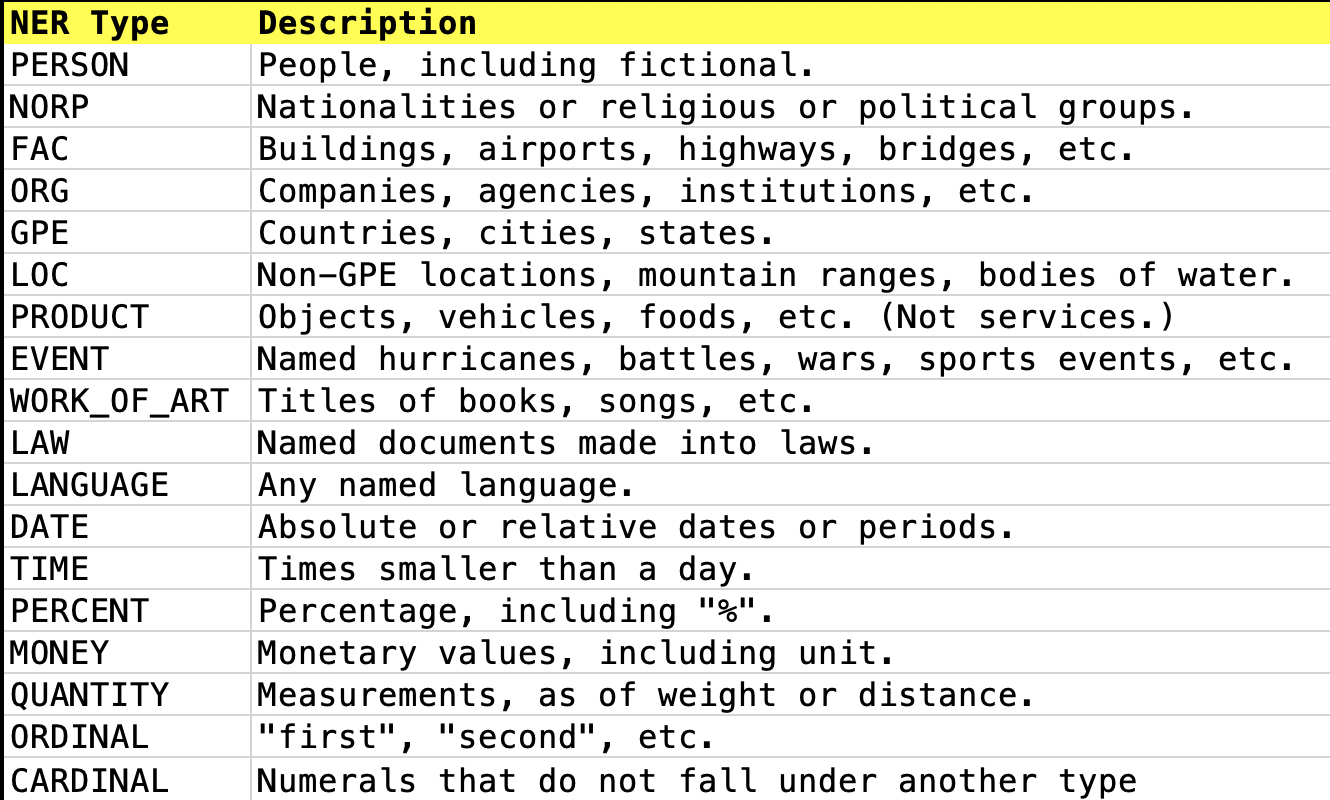

# Missing values


In [ ]:
missing_data_sum = train.isnull().sum()
missing_data = pd.DataFrame({'total_missing_values': missing_data_sum,'percentage_of_missing_values': (missing_data_sum/train.shape[0])*100})
plt.figure(figsize=(12, 5))
plt.title("Missing values percentages", fontsize=20)
chart = sns.barplot(x =missing_data['percentage_of_missing_values'] , y = train.columns, orientation='horizontal')

> Let's ignore keyword and location and explore actual text data


### Text feature length distribution

In [ ]:
train["text_length"]= train.text.apply(lambda x : len(x))

In [ ]:
def hist_plotly(target_type):
    fig_title = 'Frequency of Text Length for Not-Real Disaster Tweets'
    xaxis_name = 'Not-Real Disaster Tweets Text Length'
    if target_type == 1:
        fig_title = 'Frequency of Text Length for Real Disaster Tweets'
        xaxis_name = 'Real Disaster Tweets Text Length'
    plt2 = go.Histogram(x = train[train.target == target_type]['text_length'])
    lyt2 = go.Layout(title=fig_title, xaxis=dict(title=xaxis_name, range=[0,180]), yaxis=dict(title='Frequency'))
    fig2 = go.Figure(data=[plt2], layout=lyt2)
    iplot(fig2)
    return None
hist_plotly(1)
hist_plotly(0)

> both the distributions are symmetric

# Data Pre-Processing/Cleaning

In [ ]:
upper_text = []
punc_text = []
swd_text = []

def iterate_dataset():
    for row in train.text:
        for word in row.split():
            if word.isupper():
                upper_text.append(word)
            if word in list(string.punctuation):
                punc_text.append(word)
            if word in set(stopwords.words('english')):
                swd_text.append(word)
    return None
iterate_dataset() 

### Covert text to Lower Case

In [ ]:
# Identifying the uppercase words exists in the tweets  
print('Length of uppercase words : {}'.format(len(upper_text)))

#removing duplicates
upper_text_result = [] 
[upper_text_result.append(x) for x in upper_text if x not in upper_text_result] 
print('Length of uppercase words after removal of duplicate entries : {}'.format(len(upper_text_result)))

In [ ]:
# word cloud to see upper case words
_path ='../input/tweetimage/comment_icon.png'
draw_word_cloud(_path, 'Uppercase content', str(upper_text_result),(30, 8), max_words=300 )

In [ ]:
# Converting to lowercase
train['text'] = train.text.str.lower()
test['text'] = test.text.str.lower()

### Removal of Punctuations

In [ ]:
string.punctuation

In [ ]:
# Identifying the Punctuations exists in the tweets

print('Number of  Punctuations : {}'.format(len(punc_text)))
# Use nltk to get the frequency
punc_frequency = nltk.FreqDist(punc_text)
punc_frequency

In [ ]:
# Get lebels and values as seperate lists 
punc_fixed_list = [x for x in punc_frequency.items()]
labels,values = zip(*punc_fixed_list)
plot_donut(labels, values, 650, 'Percentage of Punctuations', 'punctuation' )

In [ ]:
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# removing punctuations
train['text'] = train['text'].apply(lambda x: remove_punctuations(x))
test['text'] = test['text'].apply(lambda x: remove_punctuations(x))

train.head()

### Removal of stopwords
* Lets first look into the language used in text feature

In [ ]:
english_vocab = set(w.lower() for w in nltk.corpus.words.words()) #vocab taken from nltk corpus
our_text_vocab = set(w.lower() for w in train.text if w.lower().isalpha())
unknown_content = our_text_vocab.difference(english_vocab) 
unknown_content

> This means apart from the above words remaining all are identifying from default nltk corus english vocabulary. 
Hence use English language for avoiding stop words

In [ ]:
swd_frequency = nltk.FreqDist(swd_text)
# Get lebels and values as seperate lists 
swd_fixed_list = [x for x in swd_frequency.items()]
labels,values = zip(*swd_fixed_list)
plot_donut(labels, values, 650, 'Percentage of Stop Words', 'stopword' )

In [ ]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])

# removing stop words
train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))

train.head()


### Removal of most common/frequent words

In [ ]:
# Lets identify most common/frequent words after removal of stop words
common_cnt = Counter()

for row in train.text:
    for word in row.split():
        common_cnt[word] += 1
        

In [ ]:
most_common_wd_frequency = nltk.FreqDist(common_cnt.most_common(10))
# Get lebels and values as seperate lists 
mcwds_fixed_list = [x for x in most_common_wd_frequency.items()]
labels,values = zip(*mcwds_fixed_list)
plot_donut(labels, values, 650, 'Percentage of Top 10 Common Words after removal of stopwords', 'common word' )

In [ ]:
freqt_words = set([word for (word, count) in common_cnt.most_common(10)])

def remove_freqtwords(text):
    return " ".join([word for word in str(text).split() if word not in freqt_words])

# removing common/frequent words
train['text'] = train['text'].apply(lambda x: remove_freqtwords(x))
test['text'] = test['text'].apply(lambda x: remove_freqtwords(x))

train.head()


###  Removal of Rare words

In [ ]:
num_rare_words = 50

rare_words = set([word for (word, counter) in common_cnt.most_common()[:-num_rare_words-1:-1]])


In [ ]:
# word cloud to see upper case words
_path ='../input/tweetimage/comment_icon.png'
draw_word_cloud(_path, 'Rare words content', str(rare_words),(30, 8), max_words=50 )

In [ ]:
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in rare_words])

# removing rare words
train['text'] = train['text'].apply(lambda x: remove_freqtwords(x))
test['text'] = test['text'].apply(lambda x: remove_freqtwords(x))

train.head()

### Apply Stemming

In [ ]:
stemmer = PorterStemmer()

def word_stemmer(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

train['text'] = train['text'].apply(lambda x: word_stemmer(x))
test['text'] = test['text'].apply(lambda x: word_stemmer(x))

train.head()


### Apply Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

train['text'] = train['text'].apply(lambda x: word_lemmatizer(x))
test['text'] = test['text'].apply(lambda x: word_lemmatizer(x))

train.head()



> Re-apply Lemmatization to preseve the meaning of the word

In [ ]:
lemmatizer = WordNetLemmatizer()

wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def word_lemmatizer(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

train['text'] = train['text'].apply(lambda x: word_lemmatizer(x))
test['text'] = test['text'].apply(lambda x: word_lemmatizer(x))

train.head()

### Removal of URLs


In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

train['text'] = train['text'].apply(lambda x: remove_urls(x))
test['text'] = test['text'].apply(lambda x: remove_urls(x))

train.head()

### Removal of HTML tags


In [ ]:
def remove_html_tags(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

train['text'] = train['text'].apply(lambda x: remove_html_tags(x))
test['text'] = test['text'].apply(lambda x: remove_html_tags(x))

train.head()

### Remove emojis

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train['text'] = train['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))

train.head()

In [ ]:
# After cleaning the text, lets check the length

train['cleaned_text_length'] = train.text.apply(lambda x : len(x))


In [ ]:
plt.figure(figsize=(25,10))
plt.title('Visualizing tweets length before and after data cleanup', fontsize=24)
plt.plot(train.text_length, label='before')
plt.plot(train.cleaned_text_length, label='after')
plt.legend();

# Model inputs readiness

In [ ]:
# Applying Bag of Words model 

count_vectorizer=CountVectorizer(analyzer='word',binary=True)
count_vectorizer.fit(train.text)

train_cnt_vec = count_vectorizer.fit_transform(train.text)
test_cnt_vec = count_vectorizer.transform(test.text)


In [ ]:
# Spliting 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(train_cnt_vec.todense(), train.target, test_size = 0.2, random_state = 42)

In [ ]:
# function to get fit the model and save the scores
train_score = []
test_score = []
def fit_model(model, model_name):
    _model = model.fit(X_train, y_train)
    train_score_val = model.score(X_train, y_train)
    test_score_val = model.score(X_test,y_test)
    train_score.append(train_score_val)
    test_score.append(test_score_val)
    print(f"{model_name} Train score :", train_score_val)
    print(f"{model_name} Test score is:",test_score_val)
    return _model

In [ ]:
fit_model(GaussianNB(), 'Gaussian Naive Bayes')

In [ ]:
fit_model(DecisionTreeClassifier(criterion="entropy", max_depth = 4), 'Decision Tree Classifier')

In [ ]:
fit_model(LogisticRegression(max_iter=1000000), 'Logistic Regression')

In [ ]:
fit_model(GradientBoostingClassifier(random_state=0), 'Gradient Boosting Classifier')

In [ ]:
fit_model(MultinomialNB(), 'Multinomial Naive Bayes')

In [ ]:
model_name = ['Gaussian NB', 'Decision Tree', 'Logistic Regression', 'Gradient Boosting Classifier', 'Multinomial NB']
plot_bar(model_name, train_score, 'Train Score w.r.to Model', 'model name', [14,5])

In [ ]:
plot_bar(model_name, test_score, 'Test Score w.r.to Model', 'model name', [14,5])

> Take away : MultinomialNB model is generalised when compared other models

# Submission
### Disaster Prediction for Test Data and Submission

In [ ]:
# lets apply MNB model on complete train data 
mnb_model = MultinomialNB()
mnb_model.fit(train_cnt_vec.todense(), train.target)

In [ ]:
# predicting test.csv data

predictions = mnb_model.predict(test_cnt_vec.todense())
predictions_test_ids=test.id.values.ravel()

In [ ]:
submission_df = pd.DataFrame({"id":predictions_test_ids,"target":predictions})
submission_df

In [ ]:
submission_df.to_csv('submission.csv', index=False)

# Conclusion

* Explored Text data. Visualized data using word clouds
* Able to identified named entity recognizers using spacy
* Done data cleaning like conversion of lower case, removal of puntuations, stop words, most used words, rare words, html tags and emogies
* Tokenized and applied BOW(Bag of Words) techique
* Verified foundational models like LR, GNB, DT, GBC and MNB
* Predicted target values for the given test dataset

## Feedback
* Your feedback is much appreciated
* Comment if you have any doubts or you found any errors in the notebook

**Happy learning!!**